In [4]:
from IPython.display import display, HTML, Math, Markdown
display(HTML("<style>.container { width:95% !important; }</style>"))

import sys
sys.path.insert(0, '../')
coralme_dir = '/home/chris/zuniga/coralme/'
sys.path.insert(0, coralme_dir)

import importlib
import coralme
import coralme.solver.solver
import coralme.builder.main
import coralme.core.model
import os
import pandas as pd
import json
import cobra
import numpy as np
import matplotlib.pyplot as plt
from coralme.util.helpers import get_nlp, optimize
import pickle

from coralme.builder.main import MEBuilder

In [5]:
# load ME and M models
base_dir = os.path.join(coralme_dir, 'species_files', 'Zymomonas_mobilis')
path = os.path.join(base_dir, 'outputs', 'MEModel-step3-zymomonas-TS.pkl')
ME_model = coralme.io.pickle.load_pickle_me_model(path)
path = os.path.join(base_dir, 'inputs', 'i_ZM4_481.json')
M_model = cobra.io.load_json_model(path)

In [17]:
ME_model.metabolites.get_by_id('ZMO1236-MONOMER')

Metabolite identifier,ZMO1236-MONOMER
Name,
Memory address,0x7f642a40d660
Formula,C1599H2553N435O488S15
Compartment,c
In 3 reaction(s),"formation_ZMO1236-MONOMER, ALCD2x_REV_ZMO1236-MONOMER, ALCD2x_FWD_ZMO1236-MONOMER"


In [11]:
rxns = list(ME_model.metabolites.get_by_id('etoh_c').reactions)

In [16]:
ME_model.reactions.get_by_id(rxns[2].id)

Reaction identifier,ALCD2x_FWD_ZMO1236-MONOMER
Name,
Memory address,0x7f642a223460
Stoichiometry,[4.13969424560965e-6*mu1] ZMO1236-MONOMER + 1.0 etoh_c + 1.0 nad_c --> 1.0 acald_c + 1.0 h_c + 1.0 nadh_c [4.13969424560965e-6*mu1] ZMO1236-MONOMER + 1.0 Ethanol + 1.0 Nicotinamide adenine dinucleotide --> 1.0 Acetaldehyde + 1.0 H+ + 1.0 Nicotinamide adenine dinucleotide - reduced
GPR,
Lower bound,0
Upper bound,1000.0
Reaction type,coralme.core.reaction.MetabolicReaction
Flux,0 ($\mu$= 0.483924)
Reduced cost,-3.19208e-06 ($\mu$= 0.483924)
Bound violation,False


In [3]:
# let's set standard starting conditions, taking the more liberal of each
for rxn in ME_model.reactions:
    ME_low = rxn.lower_bound
    ME_up = rxn.upper_bound
    try:
        M_low = M_model.reactions.get_by_id(rxn.id).lower_bound
        M_up = M_model.reactions.get_by_id(rxn.id).upper_bound
    except:
        continue
    if M_low != ME_low or M_up != ME_up:
        pass # they're all the same basically
    new_low = min([ME_low, M_low])
    new_up = max([ME_up, M_up])
    rxn.lower_bound = new_low
    rxn.upper_bound = new_up
    M_model.reactions.get_by_id(rxn.id).lower_bound = new_low
    M_model.reactions.get_by_id(rxn.id).upper_bound + new_up

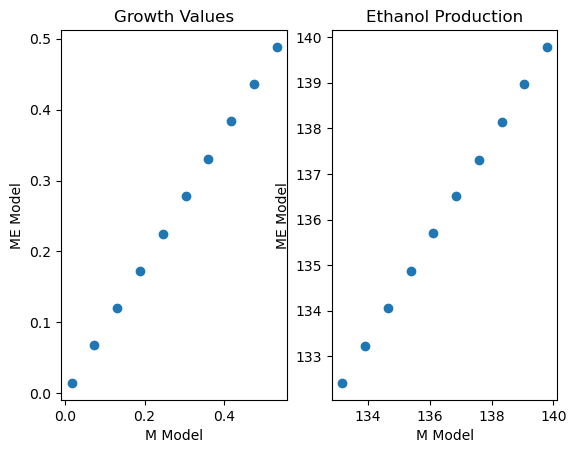

In [4]:
# let's loop through different ATP requirements, checking output
output_dict = {}
dict_path = os.path.join(coralme_dir, 'data', 'ATP_growth_etoh_output.pkl')
if os.path.exists(dict_path):
    pickle_in = open(dict_path, 'rb')
    output_dict = pickle.load(pickle_in)
    pickle_in.close()
for ATP_min in np.linspace(3, 68, 10):
    if ATP_min in output_dict:
        continue
    print('running on '+str(ATP_min))
    # set new ATP check value for both models
    M_model.reactions.get_by_id('ATPM').lower_bound = ATP_min
    M_model.reactions.get_by_id('ATPM').upper_bound = 1000
    ME_model.reactions.get_by_id('ATPM').lower_bound = ATP_min
    ME_model.reactions.get_by_id('ATPM').upper_bound = 1000
    
    # rerun both models
    M_sol = M_model.optimize()
    ME_model.optimize(tolerance = 1e-3)
    ME_sol = ME_model.solution

    # save off values
    output_dict.update({ATP_min : (M_sol.objective_value, M_sol.fluxes['EX_etoh_e'], ME_sol.objective_value, ME_sol.fluxes['EX_etoh_e'])})

pickle_out = open(dict_path, 'wb')
pickle.dump(output_dict, pickle_out)
pickle_out.close()

# plot it!
M_growth_out = []
M_etoh_out = []
ME_growth_out = []
ME_etoh_out = []
for ATP_min, vals in output_dict.items():
    M_growth_out.append(vals[0])
    M_etoh_out.append(vals[1])
    ME_growth_out.append(vals[2])
    ME_etoh_out.append(vals[3])
fig, axs = plt.subplots(1, 2)
axs[0].scatter(M_growth_out, ME_growth_out)
axs[0].set_title('Growth Values')
axs[0].set_xlabel('M Model')
axs[0].set_ylabel('ME Model')
axs[1].scatter(M_etoh_out, ME_etoh_out)
axs[1].set_title('Ethanol Production')
axs[1].set_xlabel('M Model')
axs[1].set_ylabel('ME Model')
plt.show()

working on rxn_min = 2.1052631578947367
Iteration	 Solution to check	Solver Status
---------	------------------	-------------
        1	1.4050280687025918	Not feasible
        2	0.7025140343512959	Not feasible
        3	0.3512570171756479	Optimal
        4	0.5268855257634719	Not feasible
        5	0.4390712714695599	Optimal
        6	0.4829783986165159	Optimal
        7	0.5049319621899939	Not feasible
        8	0.4939551804032549	Not feasible
        9	0.4884667895098854	Not feasible
working on rxn_min = 4.2105263157894735
Iteration	 Solution to check	Solver Status
---------	------------------	-------------
        1	1.4050280687025918	Not feasible
        2	0.7025140343512959	Not feasible
        3	0.3512570171756479	Optimal
        4	0.5268855257634719	Not feasible
        5	0.4390712714695599	Optimal
        6	0.4829783986165159	Not feasible
        7	0.4610248350430379	Optimal
        8	0.4720016168297769	Optimal
        9	0.4774900077231464	Optimal
working on rxn_min = 6.315789473

Text(0.02, 0.5, 'Isobutanol Output')

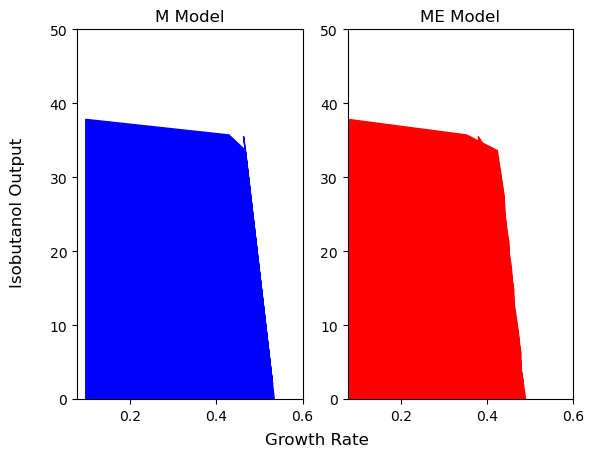

In [57]:
# let's loop through different ATP requirements, checking output of isobutanol
output_dict = {}
dict_path = os.path.join(coralme_dir, 'data', 'growth_iso_output.pkl')
if os.path.exists(dict_path):
    pickle_in = open(dict_path, 'rb')
    output_dict = pickle.load(pickle_in)
    pickle_in.close()
# set new ATP check value for both models
M_model.reactions.get_by_id('ATPM').lower_bound = 3
ME_model.reactions.get_by_id('ATPM').lower_bound = 3
M_model.reactions.get_by_id('ATPM').upper_bound = 1000
ME_model.reactions.get_by_id('ATPM').upper_bound = 1000
for rxn_min in np.linspace(0, 40, 20):
    if rxn_min in output_dict:
        continue
    print('working on rxn_min = '+str(rxn_min))
    
    # set minimum growth rate
    M_model.reactions.get_by_id('ISOB').lower_bound = rxn_min
    ME_model.reactions.get_by_id('ISOB_FWD_CPLX_dummy').lower_bound = rxn_min
    
    # rerun both models
    M_sol = M_model.optimize()
    ME_model.optimize(tolerance = 1e-2)
    try:
        ME_sol = ME_model.solution
    except:
        ME_sol = None

    # save off values
    M_growth_out = M_sol.objective_value
    M_iso_out = M_sol.fluxes['ISOB']
    if ME_sol:
        ME_growth_out = ME_sol.objective_value
        ME_iso_out = ME_sol.fluxes['ISOB_FWD_CPLX_dummy']
    else:
        ME_growth_out = 0
        ME_iso_out = 0
    output_dict.update({rxn_min : (M_growth_out, M_iso_out, M_sol, ME_growth_out, ME_iso_out, ME_sol)})
    
pickle_out = open(dict_path, 'wb')
pickle.dump(output_dict, pickle_out)
pickle_out.close()

# unload dictionary, plot
M_growth_out = []
M_iso_out = []
ME_growth_out = []
ME_iso_out = []
for rxn_min, vals in output_dict.items():
    if vals[0] != 0:
        M_growth_out.append(vals[0])
        M_iso_out.append(vals[1])
    if vals[3] != 0:
        ME_growth_out.append(vals[3])
        ME_iso_out.append(vals[4])
fig, axs = plt.subplots(1, 2)
min_growth = min([min(M_growth_out), min(ME_growth_out)])
axs[0].fill_between(M_growth_out, M_iso_out, color = 'blue')
axs[0].set_title('M Model')
axs[0].set_xlim(min_growth, .6)
axs[0].set_ylim(0, 50)
axs[1].fill_between(ME_growth_out, ME_iso_out, color = 'red')
axs[1].set_title('ME Model')
axs[1].set_xlim(min_growth, .6)
axs[1].set_ylim(0, 50)
fig.supxlabel('Growth Rate')
fig.supylabel('Isobutanol Output')

# let's look at flux to ethanol

In [55]:
# ethanol reactions from ethanol to pyruvate
rxns = ['EX_etoh_e', 'ALCD2x', 'PYRDC']
plot_df = pd.DataFrame(index = rxns)
for rxn_min in output_dict.keys():
    outputs = []
    for rxn in rxns:
        flux = output_dict[rxn_min][2][rxn]
        outputs.append(abs(flux))
    plot_df[rxn_min] = outputs

In [56]:
plot_df

,0.000000,4.444444,8.888889,13.333333,17.777778,22.222222,26.666667,31.111111,35.555556,40.000000
EX_etoh_e,133.179277,124.403501,115.627726,106.851950,98.076174,89.300398,80.524623,71.748847,63.000000,63.0
ALCD2x,133.179277,124.403501,115.627726,106.851950,98.076174,89.300398,80.524623,71.748847,63.000000,63.0
PYRDC,132.990788,124.218139,115.445489,106.672839,97.900189,89.127539,80.354889,71.582239,62.816064,60.0
